# Initialize

In [1]:
from dm import *
from qnn import *
from run import *

In [2]:
import json

def save_data(datas: dict, filename: str):
    with open(filename, "w") as f:
        json.dump(datas, f, cls=MyEncoder)


# Construct Method 1

$$
\rho = \frac{I}{8} + \sum_{i, j, k = 1}^3 t_{i, j, k} \sigma_i \otimes \sigma_j \otimes \sigma_k
$$

where $T_2 = T_3 = 0$ .

$$
T_1 = \sum_{i = 1}^m c_i \ket{u_i} \bra{u_i} \quad \text{where } c_i \in (0, 1) \text{ and } \ket{u_i} \in \Re^3
$$

Locality: 6054 / 10000
Positive: 5624 / 10000
Non-locality: 0 / 5624


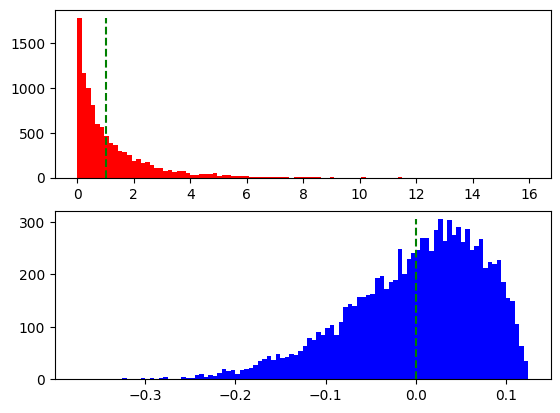

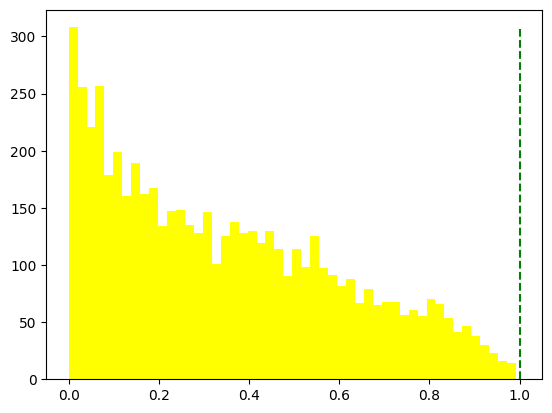

In [3]:
# test

import matplotlib.pyplot as plt

def test(n: int, m: int):
    X = np.matrix([[0, 1],
                   [1, 0]])
    Y = np.matrix([[0, -1j],
                   [1j, 0]])
    Z = np.matrix([[1, 0],
                   [0, -1]])
    sigma = [X, Y, Z]
    
    arr_eig_max = []
    arr_eig_min = []
    for i in range(n):
        T1 = generate_real_positive(3, m)
        eigens = np.linalg.eigvals(T1.T @ T1)
        eigens = eigens.real
        eig_max = eigens.max()

        T = [T1, np.zeros((3,3)), np.zeros((3,3))]
        rho = np.eye(8, 8, dtype=np.complex64)
        rho = np.asmatrix(rho)

        for i in range(3):
            for j in range(3):
                for k in range(3):
                    rho += T[k][i, j] * np.kron(np.kron(sigma[i], sigma[j]), sigma[k])
        
        rho /= rho.trace()

        eigs = np.linalg.eigvals(rho)
        eig_min = eigs.real.min()

        arr_eig_max.append(eig_max)
        arr_eig_min.append(eig_min)

    print(f"Locality: {len(list( filter(lambda x: x < 1.0, arr_eig_max) ))} / {n}")
    print(f"Positive: {len(list( filter(lambda x: x > 0.0, arr_eig_min)) )} / {n}")

    arr_positive = []
    for (e1, e2) in zip(arr_eig_min, arr_eig_max):
        if e1 > -1e-5:
            arr_positive.append(e2)
    print(f"Non-locality: {len(list(filter(lambda x: x > 1.0 - 1e-5, arr_positive)))} / {len(arr_positive)}")

    plt.subplot(211)
    (cnt, _, _) = plt.hist(arr_eig_max, bins=100, color="red")
    plt.vlines([1], 0, max(cnt), colors="green", linestyles="dashed")
    plt.subplot(212)
    (cnt, _, _) = plt.hist(arr_eig_min, bins=100, color="blue")
    plt.vlines([0], 0, max(cnt), colors="green", linestyles="dashed")
    plt.show()

    (cnt, _, _) = plt.hist(arr_positive, bins=50, color="yellow")
    plt.vlines([1], 0, max(cnt), colors="green", linestyles="dashed")
    plt.show()


test(n=10000, m=2)

Locality: 66 / 1000
Positive: 37 / 1000
Non-locality: 0 / 38


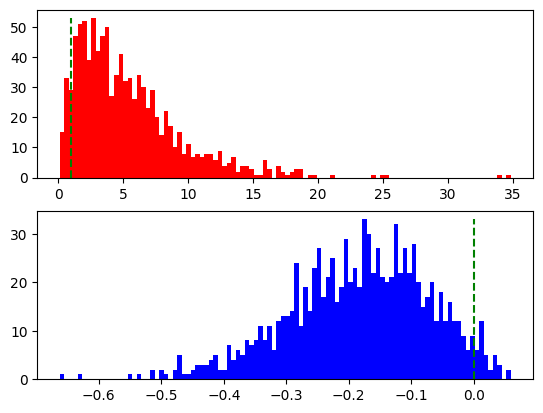

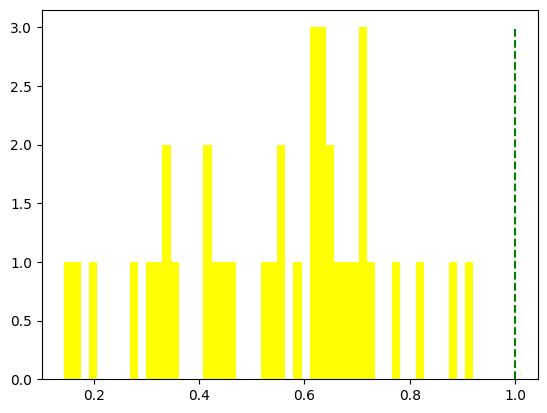

In [4]:
test(n=1000, m=5)

# Construct Method 2

$$
\rho_0 = \sum_{i, j, k = 1}^3 t_{i, j, k} \sigma_i \otimes \sigma_j \otimes \sigma_k
$$

Add $I$ till positive:

$$
\rho = \rho_0 + c I \quad \text{where } c = -\min_{e \in \text{eig}(\rho_0)} e
$$

Locality: 1000 / 1000
Positive: 1000 / 1000
Non-locality: 0 / 1000


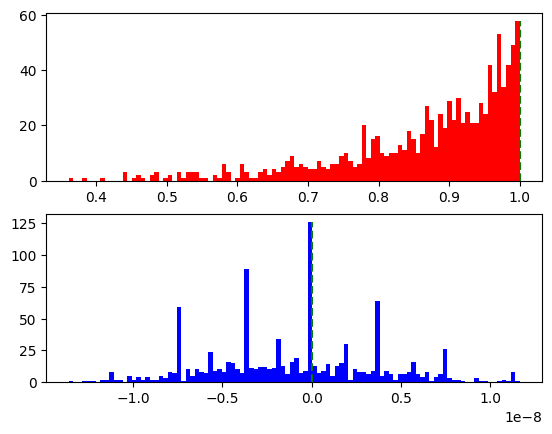

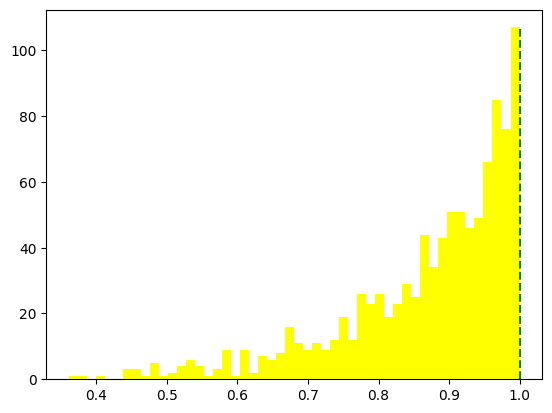

In [ ]:
# test safe

from qnn import *
from run import *
import matplotlib.pyplot as plt

def test(n: int, m: int):
    arr_eig_max = []
    arr_eig_min = []

    for i in range(n):
        T1 = generate_real_positive(3, m) * 8
        T2 = np.zeros(shape=(3,3))
        T3 = np.zeros(shape=(3,3))

        rho = from_correlation_matrices3_safe(T1, T2, T3)
        if not check_positive(rho):
            print("Error")
            break
        T1, T2, T3 = to_correlation_matrices3(rho)

        eig_of_T = np.linalg.eigvals(T1.T @ T1)
        eig_max = eig_of_T.real.max()

        eigs = np.linalg.eigvals(rho)
        eig_min = eigs.real.min()

        arr_eig_max.append(eig_max)
        arr_eig_min.append(eig_min)

    print(f"Locality: {len(list( filter(lambda x: x < 1.0, arr_eig_max) ))} / {n}")
    print(f"Positive: {len(list( filter(lambda x: x > -1e-5, arr_eig_min)) )} / {n}")

    arr_positive = []
    for (e1, e2) in zip(arr_eig_min, arr_eig_max):
        if e1 > -1e-5:
            arr_positive.append(e2)
    print(f"Non-locality: {len(list(filter(lambda x: x > 1.0, arr_positive)))} / {len(arr_positive)}")

    plt.subplot(211)
    (cnt, _, _) = plt.hist(arr_eig_max, bins=100, color="red")
    plt.vlines([1], 0, max(cnt), colors="green", linestyles="dashed")
    plt.subplot(212)
    (cnt, _, _) = plt.hist(arr_eig_min, bins=100, color="blue")
    plt.vlines([0], 0, max(cnt), colors="green", linestyles="dashed")
    plt.show()

    (cnt, _, _) = plt.hist(arr_positive, bins=50, color="yellow")
    plt.vlines([1], 0, max(cnt), colors="green", linestyles="dashed")
    plt.show()


test(n=1000, m=2)

# Construct Method 3

$$
rho = I / 8 + \sum_{i, j, k = 1}^3 t_{i, j, k} \sigma_i \otimes \sigma_j \otimes \sigma_k
$$

Randomize $A \in \Re^{3\times 3}$, calculate QR decomposition of $A$ and get $Q$.

Using $Q$ and randomize $W \in \Re^{3 \times 3}$ to generate $T_1, T_2, T_3$.

Fix $\rho$ by add some random $c$ times $\sigma_i \otimes \sigma_j \otimes \sigma_k$ where some index equal to $0$.

postive: 0 / 1000
nonlocal: 839 / 1000


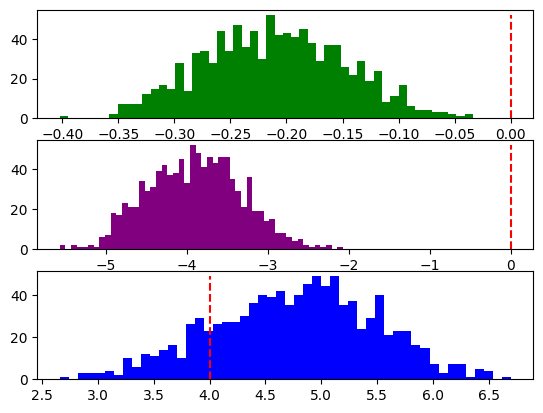

In [8]:
# test
# rho = I / 8 + \sum_{i, j, k = 1}^3 t_{i, j, k} \sigma_i \otimes \sigma_j \otimes \sigma_k

import matplotlib.pyplot as plt

def test(n: int, eta: float):
    arr_eig_min = []
    arr_s = []
    arr_eig_min_fix = []

    I = np.asmatrix(np.eye(2))
    X = np.matrix([[0, 1],
                   [1, 0]])
    Y = np.matrix([[0, -1j],
                   [1j, 0]])
    Z = np.matrix([[1, 0],
                   [0, -1]])
    sigma = [I, X, Y, Z]

    for i in range(n):
        A = np.random.random(size=(3, 3))
        Q, _ = np.linalg.qr(A)
        Q = np.asmatrix(Q)
        W = np.random.random(size=(3, 3)) * eta
        # W = np.zeros(shape=(3, 3))

        T1 = Q @ np.diag(W[0, :]) @ Q.T
        T2 = Q @ np.diag(W[1, :]) @ Q.T
        T3 = Q @ np.diag(W[2, :]) @ Q.T
        rho = from_correlation_matrices3_unchecked(T1, T2, T3)
        s = 4.0 * max(np.linalg.norm(W[:, i]) for i in range(3))

        eig_of_rho = np.linalg.eigvals(rho)
        arr_eig_min.append(eig_of_rho.real.min())
        arr_s.append(s)

        # fix rho
        for i in range(4):
            for j in range(4):
                for k in range(4):
                    if i == 0 and j == 0 and k == 0:
                        continue
                    if i != 0 and j != 0 and k != 0:
                        continue
                c = np.random.random() * eta
                rho += c * np.kron(np.kron(sigma[i], sigma[j]), sigma[k])
        eig_of_rho = np.linalg.eigvals(rho)
        arr_eig_min_fix.append(eig_of_rho.real.min())

    
    num_postive = len([_ for v in arr_eig_min if v > 1e-5])
    print(f"postive: {num_postive} / {n}")
    num_nonlocal = len([_ for s in arr_s if s > 4 + 1e-5])
    print(f"nonlocal: {num_nonlocal} / {n}")

    plt.subplot(311)
    (cnt, _, _) = plt.hist(arr_eig_min, bins=50, color="green")
    plt.vlines([0], 0, max(cnt), colors="red", linestyles="dashed")

    plt.subplot(312)
    (cnt, _, _) = plt.hist(arr_eig_min_fix, bins=50, color="purple")
    plt.vlines([0], 0, max(cnt), colors="red", linestyles="dashed")

    plt.subplot(313)
    (cnt, _, _) = plt.hist(arr_s, bins=50, color="blue")
    plt.vlines([4], 0, max(cnt), colors="red", linestyles="dashed")
    plt.show()

test(1000, 1)

postive: 1000 / 1000
nonlocal: 0 / 1000


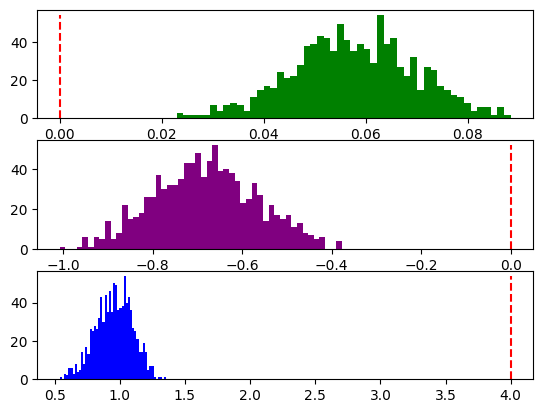

In [9]:
test(1000, 0.2)

postive: 82 / 1000
nonlocal: 0 / 1000


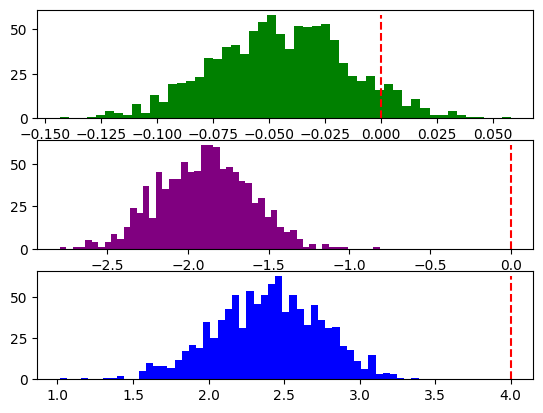

In [10]:
test(1000, 0.5)

# Pure 3-qubit

In [3]:
import matplotlib.pyplot as plt

def run_test(n: int):
    arr_s = []
    arr_e = []
    for i in range(n):
        psi = rand_state(n_qubits=3)
        entanglement = three_entanglement_pure(psi)

        psi = np.asmatrix(psi)
        rho = psi.H @ psi
        dm = DensityMatrix(rho)
        s = Svetlichny_qnn(dm)

        arr_s.append(s)
        arr_e.append(entanglement)
    
    return arr_e, arr_s
    
arr_e, arr_s = run_test(1000)

save_data({"arr_e": arr_e, "arr_s": arr_s}, "pure_q3.json")

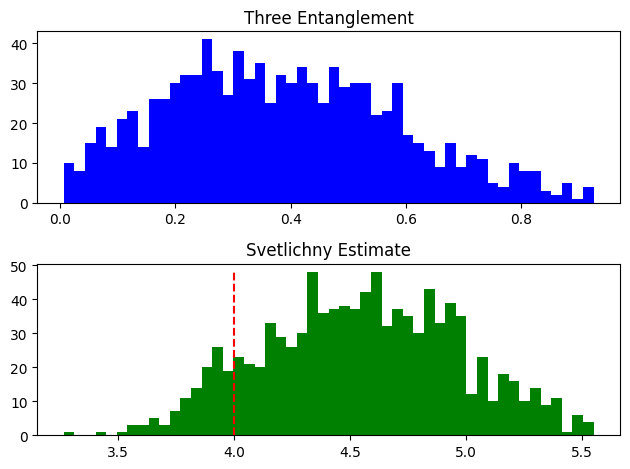

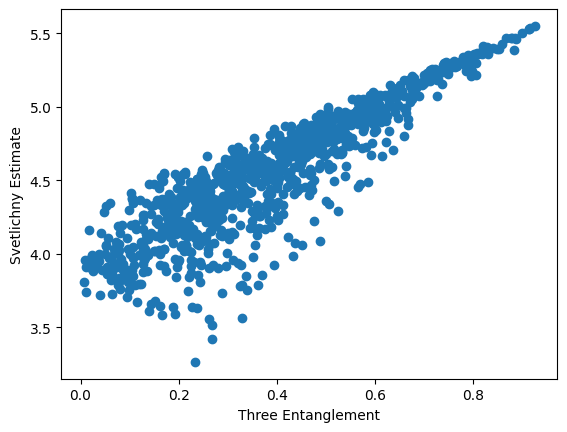

In [20]:
def draw_pure_q3():

    with open("./pure_q3.json", "r") as f:
        datas = json.load(f)
    arr_e = datas["arr_e"]
    arr_s = datas["arr_s"]

    plt.subplot(211)
    plt.title("Three Entanglement")
    plt.hist(arr_e, bins=50, color="blue")

    plt.subplot(212)
    plt.title("Svetlichny Estimate")
    (cnt, _, _) = plt.hist(arr_s,bins=50, color="green")
    plt.vlines([4], 0, max(cnt), colors="red", linestyles="dashed")

    plt.tight_layout()
    plt.show()

    plt.xlabel("Three Entanglement")
    plt.ylabel("Svetlichny Estimate")
    # plt.plot(arr_e, arr_s)
    plt.scatter(arr_e, arr_s)
    plt.show()

draw_pure_q3()

# Random 3-qubit

Consider 

$$
\rho = \sum_{i=1}^m p_i \ket{\psi_i}\bra{\psi_i}
$$

In [5]:
def run_test(n: int, m: int):
    arr_s = []
    for i in range(n):
        dm = rand_density_matrix(3, m)
        s = Svetlichny_qnn(dm)
        arr_s.append(s)
    
    save_data({"arr_s": arr_s}, f"rand_q3_n{n}_m{m}.json")
    
    return arr_s

In [6]:
for m in range(1, 5):
    print(f"m = {m}")
    run_test(1000, m)

m = 1
m = 2
m = 3
m = 4


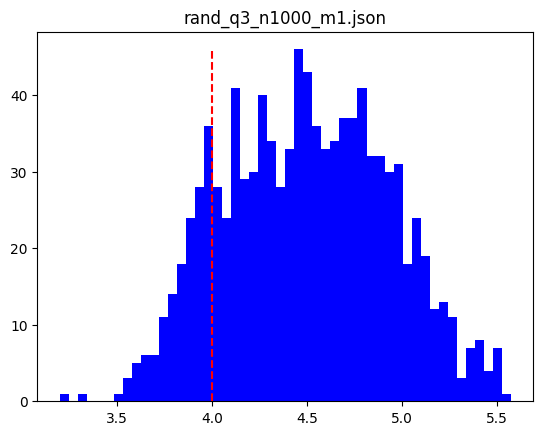

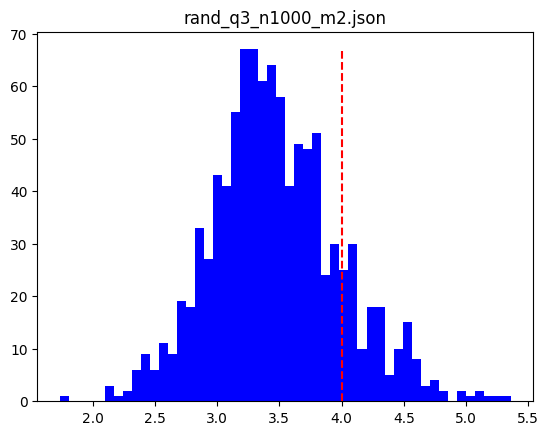

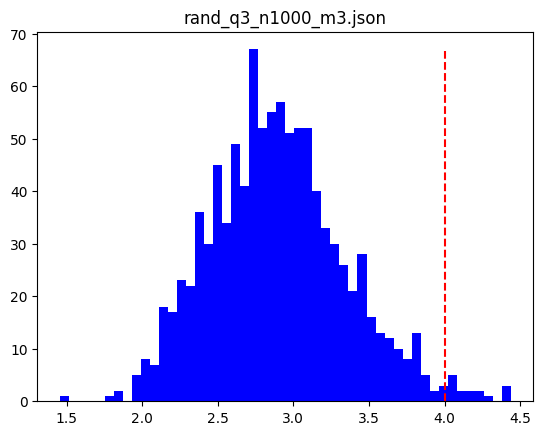

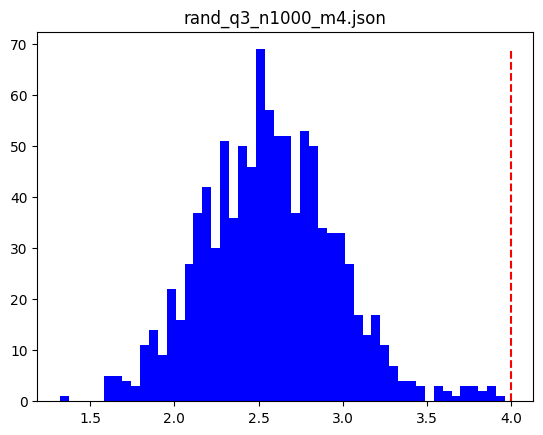

In [7]:
import matplotlib.pyplot as plt

def draw_pic(filename: str):
    with open(filename, "r") as f:
        datas = json.load(f)
    arr_s = datas["arr_s"]
    
    plt.title(filename)
    (cnt, _, _) = plt.hist(arr_s, bins=50, color="blue")
    plt.vlines([4.0], 0, max(cnt), colors="red", linestyles="dashed")
    plt.show()

for m in range(1, 5):
    draw_pic(f"rand_q3_n1000_m{m}.json")

# Random in high dimension space

Consider random vectors in $V^n$, where $V = \mathbb{R}$ or $V = \mathbb{C}$. Compute the angles between these vectors with $n$ increasing.

In [8]:
import matplotlib.pyplot as plt

def compute_angles(dim: int, num: int, is_complex: bool):
    xs = np.random.uniform(-1, 1, size=(num, dim))
    if is_complex:
        xs += np.random.uniform(-1, 1, size=(num, dim))
    # normalize x
    for i in range(num):
        xs[i, :] /= np.linalg.norm(xs[i, :])
    
    y = np.random.uniform(-1, 1, size=(dim, ))
    if is_complex:
        y += np.random.uniform(-1, 1, size=(dim, ))
    # normalize y
    y /= np.linalg.norm(y)

    # compute inner product
    ip = xs @ y
    thetas = np.arccos(ip)
    
    plt.hist(thetas, bins=50, color="blue")
    plt.show()


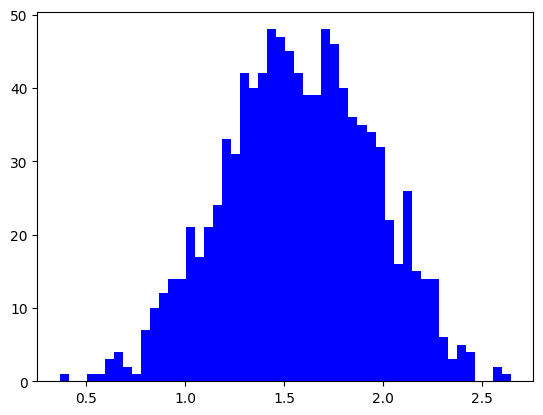

In [9]:
compute_angles(8, 1000, True)

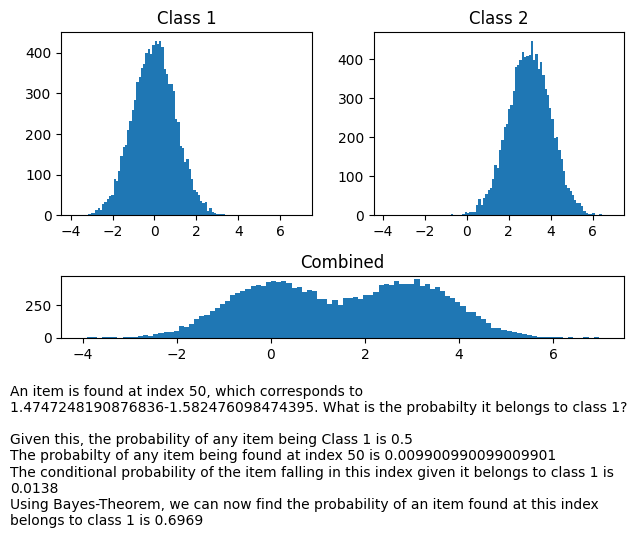

In [18]:
def test():
    bincount = 100
    mean, stdev, population = 0, 1, 10000
    separation = 3*stdev

    norm1 = np.random.normal(mean, stdev, population)
    norm2 = np.random.normal(mean + separation, stdev, population)
    comb = np.concatenate([norm1, norm2]) #concatenate nd_arrays

    fig = plt.figure("Bayesian")

    plt.subplot2grid((4, 4), (2, 0), colspan=4, rowspan=1)
    plt.title("Combined")
    hist3 = plt.hist(comb, bincount) #population, bins, patch = plt.hist()

    plt.subplot2grid((4, 4), (0, 0), colspan=2, rowspan=2)
    plt.title("Class 1")
    hist1 = plt.hist(norm1, bins=hist3[1])

    plt.subplot2grid((4, 4), (0, 2), colspan=2, rowspan=2)
    plt.title("Class 2")
    hist2 = plt.hist(norm2, bins=hist3[1])

    index = int(len(hist3[1])/2)#arbitrarily choosing the middle bin
    bin = hist3[1][index]
    binsize = (max(hist3[1])-min(hist3[1]))/len(hist3[1])
    probIndex = 1/len(hist3[1])
    probClass = len(norm1)/len(comb)
    condProbClass = hist1[0][index]/sum(hist1[0])
    condProbIndex = probClass*condProbClass/probIndex

    t = "An item is found at index {idx}, which corresponds to {binStart}-{binEnd}. What is the probabilty it belongs to class 1?\n\n"\
        "Given this, the probability of any item being Class 1 is {pC1}\n"\
        "The probabilty of any item being found at index {idx} is {pInd}\n"\
        "The conditional probability of the item falling in this index given it belongs to class 1 is {cpC1}\n"\
        "Using Bayes-Theorem, we can now find the probability of an item found at this index belongs to class 1 is {cpI}"\
        .format(
        idx=index,
        binStart=bin-binsize/2,
        binEnd=bin+binsize/2,
        pC1=probClass,
        pInd=probIndex,
        cpC1=condProbClass,
        cpI=condProbIndex
    )

    plt.tight_layout()
    plt.figtext(0, -0.1, t, wrap=True)
    plt.show()

test()